In [1]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import time

import gym.spaces
import gym
import FastSLAM

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

In [2]:
# device = torch.device('cpu')
# torch.cuda.is_available()

In [3]:
N_eps = 100
sim_time = 10.0
gamma = 0.9
_render = False
log_interval = 10
state_size = 12

TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward', 'score'])
Transition = namedtuple('Transition', ['s', 'a', 'a_log_p', 'r', 's_'])

In [4]:
class ActorNet(nn.Module):

    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Linear(state_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.mu_head = nn.Linear(100, 1)
        self.sigma_head = nn.Linear(100, 1)

    def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        mu = self.mu_head(x)
        sigma = F.sigmoid(self.sigma_head(x))
        return (mu, sigma)


class CriticNet(nn.Module):

    def __init__(self):
        super(CriticNet, self).__init__()
        self.fc1 = nn.Linear(state_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.v_head = nn.Linear(100, 1)

    def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        state_value = self.v_head(x)
        return state_value

In [5]:
class Agent():

    clip_param = 0.2
    max_grad_norm = 0.5
    ppo_epoch = 100
    buffer_capacity, batch_size = 1000, 32

    def __init__(self):
        self.training_step = 0
        self.anet = ActorNet().float()
        self.cnet = CriticNet().float()
        self.buffer = []
        self.counter = 0

        self.optimizer_a = optim.Adam(self.anet.parameters(), lr=1e-4)
        self.optimizer_c = optim.Adam(self.cnet.parameters(), lr=3e-4)

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            (mu, sigma) = self.anet(state)
        dist = Normal(mu, sigma)
        action = dist.sample()
        action_log_prob = dist.log_prob(action)
#         action.clamp(-2.0, 2.0)
        return action.item(), action_log_prob.item(), mu.numpy()[0][0], sigma.numpy()[0][0]

    def get_value(self, state):

        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            state_value = self.cnet(state)
        return state_value.item()

    def store(self, transition):
        self.buffer.append(transition)
        self.counter += 1
        return self.counter % self.buffer_capacity == 0

    def update(self):
        self.training_step += 1

        s = torch.tensor([t.s for t in self.buffer], dtype=torch.float)
        a = torch.tensor([t.a for t in self.buffer], dtype=torch.float).view(-1, 1)
        r = torch.tensor([t.r for t in self.buffer], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in self.buffer], dtype=torch.float)

        old_action_log_probs = torch.tensor(
            [t.a_log_p for t in self.buffer], dtype=torch.float).view(-1, 1)

        r = (r - r.mean()) / (r.std() + 1e-5)
        with torch.no_grad():
            target_v = r + gamma * self.cnet(s_)

        adv = (target_v - self.cnet(s)).detach()

        for _ in range(self.ppo_epoch):
            for index in BatchSampler(
                    SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, False):

                (mu, sigma) = self.anet(s[index])
                dist = Normal(mu, sigma)
                action_log_probs = dist.log_prob(a[index])
                ratio = torch.exp(action_log_probs - old_action_log_probs[index])

                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param,
                                    1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()

                self.optimizer_a.zero_grad()
                action_loss.backward()
                nn.utils.clip_grad_norm_(self.anet.parameters(), self.max_grad_norm)
                self.optimizer_a.step()

                value_loss = F.smooth_l1_loss(self.cnet(s[index]), target_v[index])
                self.optimizer_c.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(self.cnet.parameters(), self.max_grad_norm)
                self.optimizer_c.step()

        del self.buffer[:]

In [6]:
env = gym.make('FastSLAM-v0')

agent = Agent()

opt_times = []
training_records = []
running_reward = 0
state = env.reset()
for i_ep in range(N_eps):
    score = 0
    state = env.reset()

    while env.time < sim_time:
        action, action_log_prob, _, _ = agent.select_action(state)
        state_, reward, done, _ = env.step([action])

        if _render:
            env.render_world()
            display.clear_output(wait=True)
            plt.pause(0.001)
        
        if agent.store(Transition(state, action, action_log_prob, reward, state_)):
            t1 = time.time()
            agent.update()
            t2 = time.time()
            opt_times.append(t2-t1)
            
        score += reward
        state = state_

    running_reward = running_reward * 0.9 + score * 0.1
    training_records.append(TrainingRecord(i_ep, running_reward, score))

    if len(opt_times) == 0:
        avg_opt_time = 0.0
    else:
        avg_opt_time = sum(opt_times) / float(len(opt_times))
    
    if i_ep % log_interval == 0:
        print('Ep {}\tMoving average score: {:.2f}\tAverage opt time: {:.2f}\t'.format(i_ep, running_reward, avg_opt_time))

/home/ggrg/Documents/gym/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Ep 0	Moving average score: 26.10	Average opt time: 0.00	
Ep 10	Moving average score: 21.53	Average opt time: 7.77	
Ep 20	Moving average score: 25.87	Average opt time: 7.21	
Ep 30	Moving average score: 56.50	Average opt time: 6.97	
Ep 40	Moving average score: 26.59	Average opt time: 7.05	
Ep 50	Moving average score: 58.24	Average opt time: 7.30	
Ep 60	Moving average score: 22.02	Average opt time: 7.35	
Ep 70	Moving average score: 83.68	Average opt time: 7.35	
Ep 80	Moving average score: 84.38	Average opt time: 7.37	
Ep 90	Moving average score: 117.04	Average opt time: 7.33	


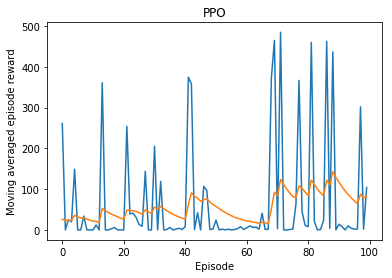

In [7]:
# env.close()
plt.plot([r.ep for r in training_records], [r.score for r in training_records])
plt.plot([r.ep for r in training_records], [r.reward for r in training_records])
plt.title('PPO')
plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
plt.show()

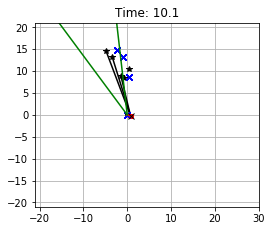

In [9]:
# env = gym.make('FastSLAM-v0')
# agent = Agent()
state = env.reset()
a_, r_, mu_, sigma_, _state_ = [], [], [], [], []

while env.time < sim_time:
    _state_.append(state)
#     print(state)
    action, action_log_prob, mu, sigma = agent.select_action(state)
    state_, reward, done, _ = env.step([action])
    a_.append([action])
    r_.append(reward)
    mu_.append(mu)
    sigma_.append(sigma)
    state = state_
    env.render_world()
    display.clear_output(wait=True)
    plt.pause(0.001)
    